In [3]:
!pip install -q gdown

In [4]:
import gdown
# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=aae11823-fa32-479e-a46d-84e78d964805
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:08<00:00, 42.8MB/s]


'TP1-3-natural-scenes.zip'

In [5]:
import zipfile
with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-3')

In [6]:
import tensorflow as tf
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling

# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Análisis exploratorio de datos
El dataset consiste en un conjunto de imágenes clasificado en:
- buildings
- forest
- glacier
- mountain
- sea
- street

También se encuentra segmentado en un conjunto de entrenamiento con alrededor de 14000 imágenes, uno de test con 3000 para evaluar el modelo y uno de 7000 para hacer inferencia con el modelo.

El modelo a desarrollar cumplirá la tarea de clasificación. Sin embargo primero realizaremos un análisis exploratorio de los datos, evaluando los atributos de las imágenes, determinar si el dataset está balanceado o no, entre otros.

Image width: 150
Image height: 150
Number of channels: 3


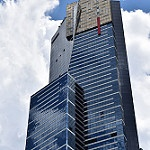

In [7]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

sample_image_path = '/content/TP1-3/seg_test/seg_test/buildings/20057.jpg'
img = cv2.imread(sample_image_path)
height, width, channels = img.shape

# Display image attributes
print("Image width:", width)
print("Image height:", height)
print("Number of channels:", channels)

cv2_imshow(img)

Por seguridad, aseguremosnos de que todas las imagenes tengan la misma dimensión al cargarlas.

Siguiendo el trabajo realizado en VGGNET, se toma un batchsize de 256

In [8]:
#categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
# Usaremos la librería tensorflow para cargar las imágenes
training_folder = '/content/TP1-3/seg_train/seg_train'
test_folder = '/content/TP1-3/seg_test/seg_test'
batch_size = 256
img_width = 150
img_height = 150

# Realizamos el split del training set
train_data = tf.keras.utils.image_dataset_from_directory(
  training_folder,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_data = tf.keras.utils.image_dataset_from_directory(
  training_folder,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
  test_folder,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


In [9]:
class_names = train_data.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

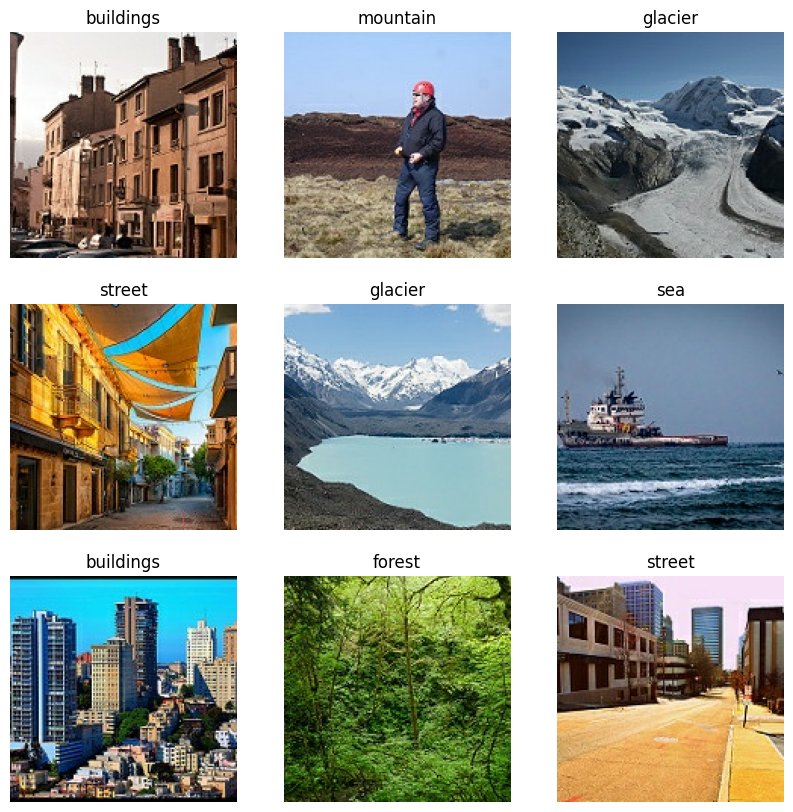

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Balanceo
Debemos observar la distribución de la cantidad de imagenes por clase para poder tener en cuenta futuros problemas de balanceo.

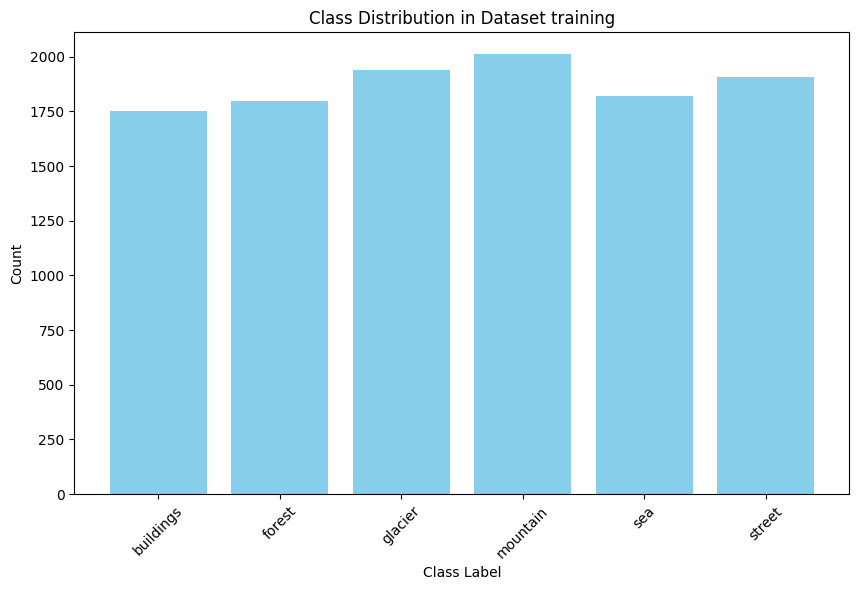

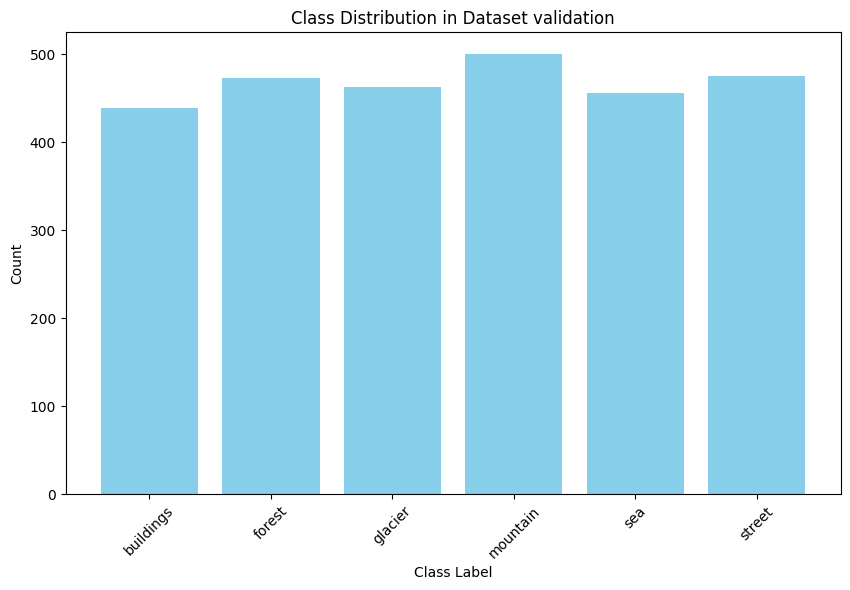

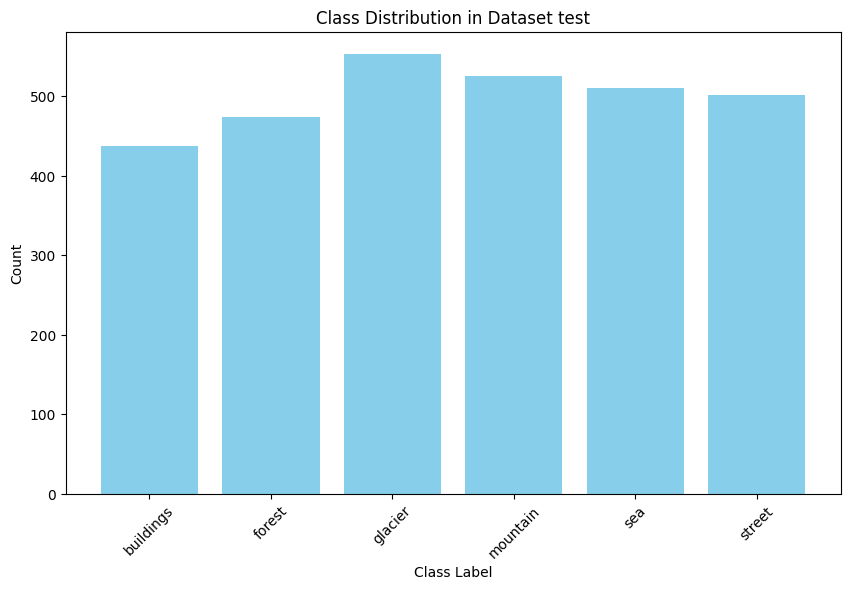

In [ ]:
# Analizar el balance de los datos
# Step 1: Iterate through the dataset and count occurrences of each class label
def graph_balance(dataset, name):
  class_counts = {class_name: 0 for class_name in class_names}
  for _, labels in dataset:
      for label in labels.numpy():
          #label = str(label)  # Convert label to string for dictionary key
          if class_names[label] in class_counts:
              class_counts[class_names[label]] += 1
          else:
              class_counts[class_names[label]] = 1

  # Step 2: Plot the counts of each class label using a bar plot
  plt.figure(figsize=(10, 6))
  plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
  plt.xlabel('Class Label')
  plt.ylabel('Count')
  plt.title(f'Class Distribution in Dataset {name}')
  plt.xticks(rotation=45)
  plt.show()

graph_balance(train_data, 'training')
graph_balance(val_data, 'validation')
graph_balance(test_data, 'test')

Observamos que contamos con un dataset balanceado. En ninguno de los datasets tenemos discrepancias considerables respecto al balance de clases.

## Promedio de imágenes
Tomemos el promedio de las imágenes respecto de cada clase para ver si existe algún patron en las intensidades de los canales. De esta manera, podemos tratar de entender qué tendencias lineales podría llegar a tomar el modelo como así también tener consideraciones acerca del data drift en el caso de que se quiera hacer inferencia con otras imágenes (un bosque que no sea verde, una montaña que sea vista desde el cielo, etc)

In [ ]:
class_images = {class_name: [] for class_name in class_names}

# Iterate through the dataset and group images by class labels
for images, labels in train_data:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]  # Get class name from label
        class_images[class_name].append(image.numpy())

# Step 2: Calculate the mean image for each class
class_mean_images = {}
for class_name, images in class_images.items():
    class_mean_images[class_name] = np.mean(images, axis=0)

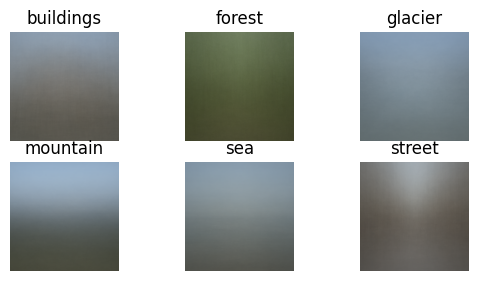

In [ ]:
for i, label in enumerate(class_names):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(class_mean_images[label].astype("uint8"))
    plt.title(label)
    plt.axis("off")

Podemos notar ciertos patrones en cada clase, como por ejemplo la dominancia del color verde en forest o los patrones de ciertas clases

Concluímos este análisis revisando los valores promedios de los canales para cada clase.


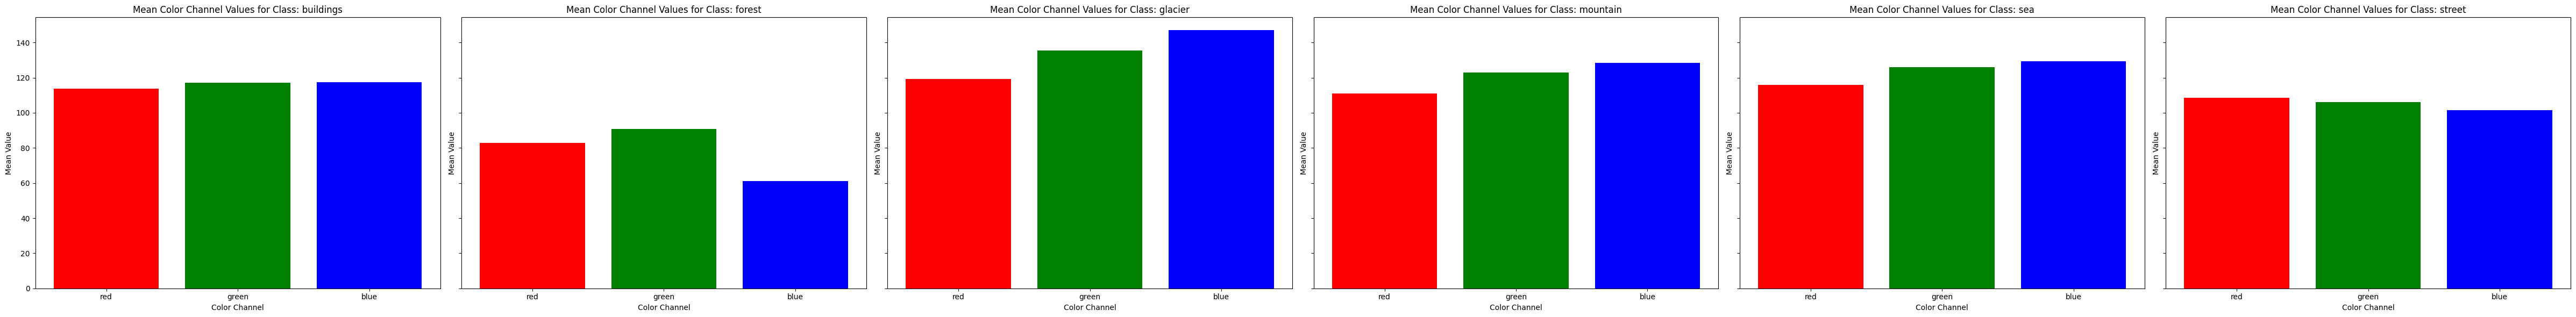

In [ ]:
import matplotlib.pyplot as plt

# Function to plot mean color channel values for a class
def plot_class_mean(ax, class_name, mean_image):
    channel_means = np.mean(mean_image, axis=(0, 1))  # Calculate mean values for each color channel
    colors = ['red', 'green', 'blue']
    ax.bar(colors, channel_means, color=colors)
    ax.set_xlabel('Color Channel')
    ax.set_ylabel('Mean Value')
    ax.set_title(f'Mean Color Channel Values for Class: {class_name}')

# Create subplots for each class
fig, axs = plt.subplots(1, len(class_mean_images), figsize=(8*len(class_mean_images), 6), sharey=True)

# Iterate through each class and plot mean color channel values
for i, (class_name, mean_image) in enumerate(class_mean_images.items()):
    plot_class_mean(axs[i], class_name, mean_image)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Preprocesamiento de datos
Inspirandonos en el paper de [VGGNet](https://arxiv.org/abs/1409.1556), se determina un preprocesamiento a realizar que será el de restar el promedio de cada canal. Computamos los promedios con los datos de entrenamiento. Además, realizaremos reescalamiento dentro del modelo para llevar los valores alrededor del cero.

Este procesamiento será aplicado solo en las redes neuronales convolucionales

In [ ]:
all_images = []
for images, _ in train_data:
  for image in images:
    all_images.append(image)
mean_image = np.mean(all_images, axis=(0))
mean_channels = np.mean(mean_image, axis=(0,1))

In [ ]:
mean_channels

# Definición de modelos
## Red neuronal densa
Como primer modelo, se nos pide que definamos uno con redes neuronales densas. Recordemos que las redes neuronales densas para imágenes no son la opción más acorde y que estamos utilizandolas con fines investigacionales.

In [ ]:
def build_model(input_shape, output_labels):
  i = Input(input_shape, dtype=tf.float32)

  x = i - mean_channels
  x = Rescaling(1./255)(x)
  x = Flatten()(x)
  x = Dense(50)(x)
  x = Dense(50)(x)
  x = Dense(output_labels)(x)
  x = Activation('softmax')(x)
  return tf.keras.Model(inputs=[i], outputs=[x])

In [ ]:
print("Building model")
model = build_model((height, width, channels), len(class_names))

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'],
    run_eagerly=True)

Building model


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.subtract (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 50)                3375050   
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                             

In [11]:
# TEMPORAL. Volvemos a definir el split especificando el label_mode para poder permitir categorical_crossentropy
train_data = tf.keras.utils.image_dataset_from_directory(
  training_folder,
  validation_split=0.2,
  subset="training",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_data = tf.keras.utils.image_dataset_from_directory(
  training_folder,
  validation_split=0.2,
  subset="validation",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
  test_folder,
  seed=123,
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=batch_size,
)

Epoch 1/10
44/44 [==============================] - 10s 157ms/step - loss: 0.5027 - accuracy: 0.8311 - val_loss: 2.1936 - val_accuracy: 0.4455
Epoch 2/10
44/44 [==============================] - 11s 225ms/step - loss: 0.4833 - accuracy: 0.8359 - val_loss: 2.0714 - val_accuracy: 0.4551
Epoch 3/10
44/44 [==============================] - 9s 184ms/step - loss: 0.3874 - accuracy: 0.8774 - val_loss: 2.1329 - val_accuracy: 0.4440
Epoch 4/10
44/44 [==============================] - 8s 160ms/step - loss: 0.4778 - accuracy: 0.8387 - val_loss: 2.3225 - val_accuracy: 0.4483
Epoch 5/10
44/44 [==============================] - 9s 173ms/step - loss: 0.4092 - accuracy: 0.8644 - val_loss: 2.2394 - val_accuracy: 0.4808
Epoch 6/10
44/44 [==============================] - 9s 182ms/step - loss: 0.3555 - accuracy: 0.8848 - val_loss: 2.5008 - val_accuracy: 0.4483
Epoch 7/10
44/44 [==============================] - 9s 180ms/step - loss: 0.3554 - accuracy: 0.8785 - val_loss: 2.5132 - val_accuracy: 0.4490
Epoc

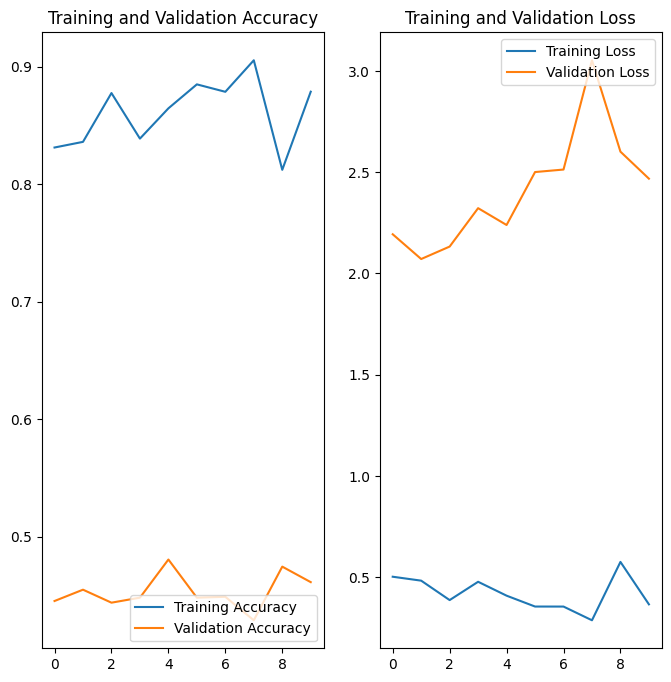

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusión
Como podemos ver, una red neuronal densa es una muy mala arquitectura para un modelo de imagenes. Esto puede deberse a diversos motivos:
- El hecho de que cada neurona tome información de todos los píxeles de la imagen hace que el modelo no tenga entendimiento acerca de la estructura de esta, pues todos los píxeles parecen iguales para cada neurona.
- Por el motivo anterior, también se descarta el dropout, ya que al hacerlo se pierde demasiada precision.
- Además, el modelo cuenta con una cantidad de parámetros muy grande, lo que dificulta tanto el entrenamiento como la inferencia.

Por todo esto, se puede observar que el modelo tiene overfitting, ya que no generaliza a casos fuera del training set.

## Red Convolucional
Para intentar solucionar este problema, intentamos utilizar una red neuronal convolucional. Esta toma como entrada datos en tipo de grilla, como lo puede ser una imagen con canales, y cada capa en lugar de tomar todas las neuronas aplica convolución y pooling.

### Primer red neuronal
#### Arquitectura
Como más adelante queremos usar ResNet, intentemos replicar el problema presente en las CNN altamente profundas del vanishing/explosive gradient descent. Para esto, proponemos como arquitectura dos redes neuronales: una que tenga una profundidad estándar y otra con una profundidad más alta. Esto se hace con el fin de poder observar cómo entrena cada modelo bajo la misma cantidad de épocas.

#### Aumentación de datos
Para darle más robustez al modelo, realizamos una serie de modificaciones a las imágenes para así evitar o reducir el overfitting. Estas modificaciones están presentes luego del rescaling, las cuales consisten en RandomFlips, translation y contrast.

In [ ]:
# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = i - mean_channels
    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(100)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

In [ ]:
print("Building model")
model_conv1 = build_model((height, width, channels), len(class_names))

model_conv1.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'],
    run_eagerly=True)

Building model


In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 20
# Entrena el modelo
history_conv1 = model_conv1.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=batch_size,
)

Epoch 1/20
44/44 [==============================] - 32s 529ms/step - loss: 1.5641 - accuracy: 0.3579 - val_loss: 1.2298 - val_accuracy: 0.5132
Epoch 2/20
44/44 [==============================] - 16s 343ms/step - loss: 1.1986 - accuracy: 0.5216 - val_loss: 1.0155 - val_accuracy: 0.5902
Epoch 3/20
44/44 [==============================] - 16s 341ms/step - loss: 1.0043 - accuracy: 0.6074 - val_loss: 0.8694 - val_accuracy: 0.6718
Epoch 4/20
44/44 [==============================] - 17s 359ms/step - loss: 0.8959 - accuracy: 0.6527 - val_loss: 0.8465 - val_accuracy: 0.6793
Epoch 5/20
44/44 [==============================] - 16s 340ms/step - loss: 0.8282 - accuracy: 0.6825 - val_loss: 0.7557 - val_accuracy: 0.7227
Epoch 6/20
44/44 [==============================] - 16s 356ms/step - loss: 0.7930 - accuracy: 0.7040 - val_loss: 0.8382 - val_accuracy: 0.6932
Epoch 7/20
44/44 [==============================] - 17s 357ms/step - loss: 0.7301 - accuracy: 0.7292 - val_loss: 0.6976 - val_accuracy: 0.7423

In [ ]:
model_conv1.summary()

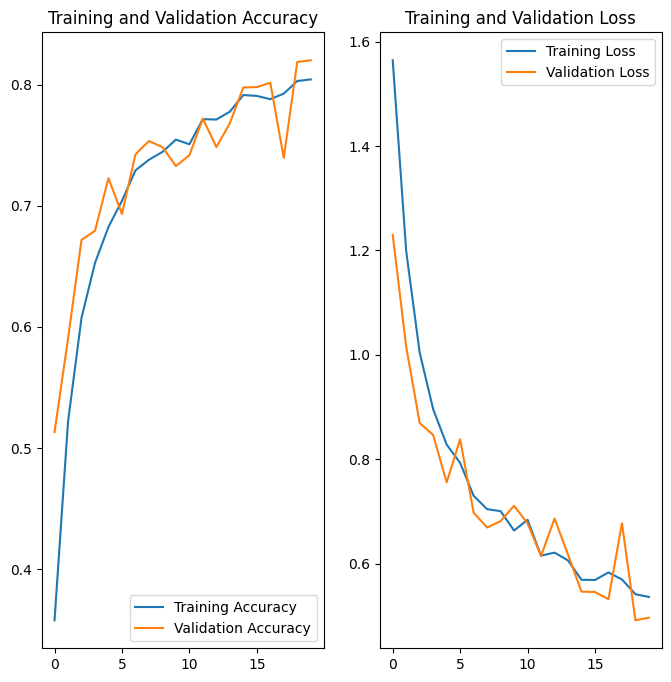

In [ ]:
import matplotlib.pyplot as plt
# Grafica la precisión y pérdida de entrenamiento y validación

acc = history_conv1.history['accuracy']
val_acc = history_conv1.history['val_accuracy']

loss = history_conv1.history['loss']
val_loss = history_conv1.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# liberamos memoria
del model_conv1

#### Observaciones
Como podemos ver, la red neuronal propuesta tiene un buen desempeño. En 20 épocas se logra una precisión por arriba del 75% para ambos entrenamiento y validación. Podemos ver también que gracias a la normalización y aumentación de datos se evitó sufrir de overfitting, además del uso de una red neuronal convolucional.

### Segunda red neuronal
El trabajo realizado en el paper [VGGNet](https://arxiv.org/pdf/1409.1556) investiga la importancia de la profundidad en las redes neuronales convolucionales. Si bien la anterior red neuronal tuvo un buen desempeño, para lograr una precisión excepcional debemos sacar provecho de la profundidad.

En este modelo, se trata de agregar un mayor número de capas mientras se trata de no sobrecargar al entorno de Colab. Intentamos replicar el modelo A de VGGNet.

In [ ]:
# Función para construir el modelo
def build_model2(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = i - mean_channels
    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(256, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(512, (3, 3))(x)
    x = Activation("relu")(x)


    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(512, (3, 3))(x)
    x = Activation("relu")(x)


    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(100)(x)
    x = Dense(50)(x)
    x = Dense(50)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

In [ ]:
print("Building model")
model_conv2 = build_model2((height, width, channels), len(class_names))

model_conv2.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'],
    run_eagerly=True)

Building model


In [ ]:
model_conv2.summary()

In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 20
# Entrena el modelo
history_conv2 = model_conv2.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=batch_size,
)

Epoch 1/20
44/44 [==============================] - 120s 2s/step - loss: 1.7016 - accuracy: 0.2441 - val_loss: 1.4778 - val_accuracy: 0.3503
Epoch 2/20
44/44 [==============================] - 44s 995ms/step - loss: 1.4039 - accuracy: 0.3922 - val_loss: 1.2121 - val_accuracy: 0.4936
Epoch 3/20
44/44 [==============================] - 43s 967ms/step - loss: 1.1607 - accuracy: 0.5081 - val_loss: 1.0074 - val_accuracy: 0.5567
Epoch 4/20
44/44 [==============================] - 44s 995ms/step - loss: 1.0808 - accuracy: 0.5371 - val_loss: 0.9724 - val_accuracy: 0.5873
Epoch 5/20
44/44 [==============================] - 43s 971ms/step - loss: 1.0326 - accuracy: 0.5577 - val_loss: 0.9780 - val_accuracy: 0.5834
Epoch 6/20
44/44 [==============================] - 44s 970ms/step - loss: 0.9829 - accuracy: 0.5819 - val_loss: 0.9044 - val_accuracy: 0.6098
Epoch 7/20
44/44 [==============================] - 44s 993ms/step - loss: 0.9451 - accuracy: 0.5957 - val_loss: 0.8341 - val_accuracy: 0.6486
E

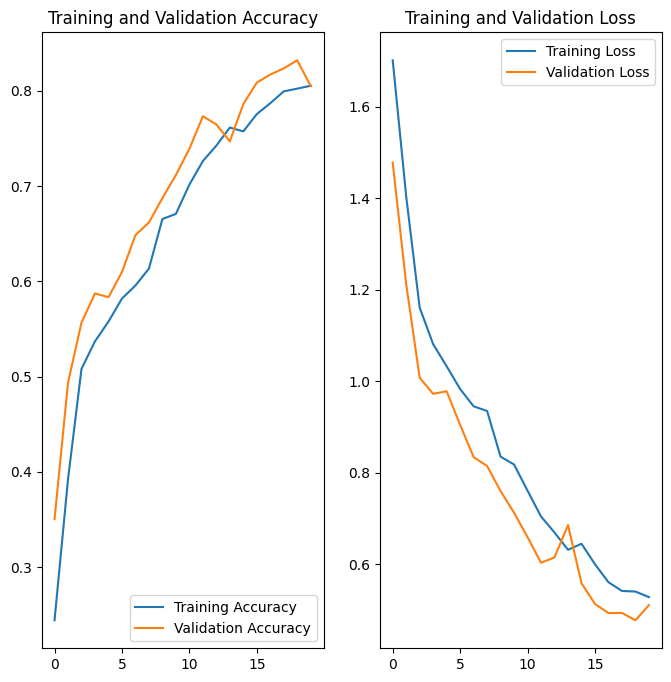

In [ ]:
import matplotlib.pyplot as plt
# Grafica la precisión y pérdida de entrenamiento y validación

acc = history_conv2.history['accuracy']
val_acc = history_conv2.history['val_accuracy']

loss = history_conv2.history['loss']
val_loss = history_conv2.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Comparando entrenamientos
Comparemos ahora la precisión de entrenamiento y validación entre estos dos modelos

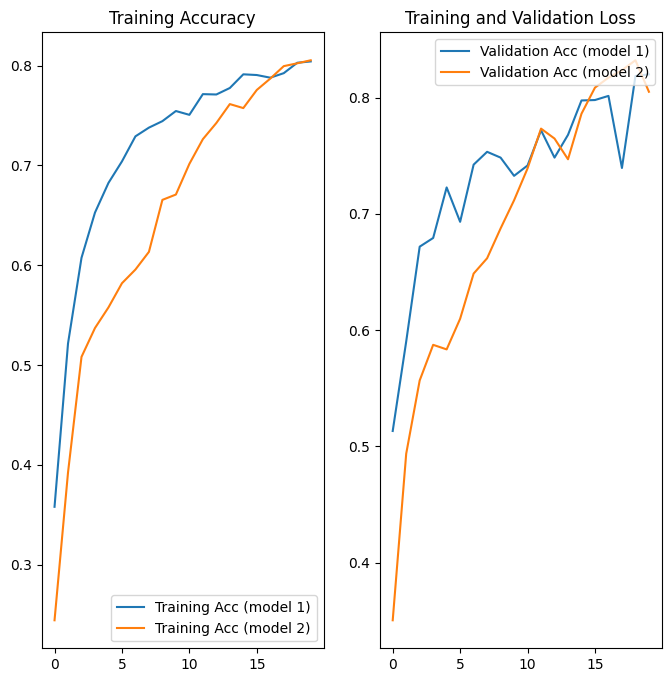

In [ ]:

acc1 = history_conv1.history['accuracy']
val_acc1 = history_conv1.history['val_accuracy']

acc2 = history_conv2.history['accuracy']
val_acc2 = history_conv2.history['val_accuracy']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label='Training Acc (model 1)')
plt.plot(epochs_range, acc2, label='Training Acc (model 2)')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_acc1, label='Validation Acc (model 1)')
plt.plot(epochs_range, val_acc2, label='Validation Acc (model 2)')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observaciones en la comparación
A pesar de que el modelo 2 sobrepasó en precisión al modelo 1 (lo cual puede ser explicado a que el modelo 1 ya había convergido), se puede observar en el resto del entrenamiento que el segundo modelo presenta dificultades reduciendo el costo en cada epoca comparado con el primer modelo. Como mencionamos antes, esto puede deberse al problema del descenso de gradiente desvaneciente, por lo que analizaremos cómo solucionarlo para así lograr una convergencia rápida y mantener la alta profundidad del modelo.

Aún así, algo que podemos suponer observando las gráficas es que el primer modelo está muy cerca de converger o ya lo hizo, mientras que el segundo parece poder seguir mejorando sus métricas.

## Bloques residuales
Para poder tratar el problema del descenso del gradiente descendiente, se propone incluir los bloques residuales planteados en el paper [ResNet](https://arxiv.org/pdf/1512.03385)

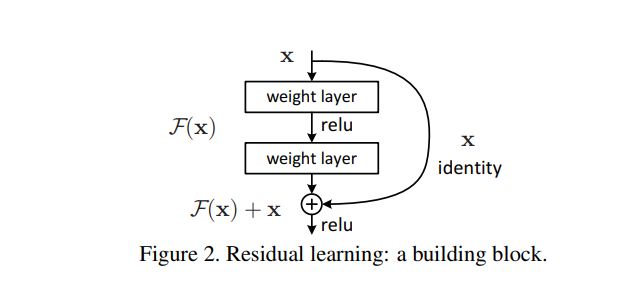

Como se puede observar en el gráfico, un bloque residual consiste en una serie de capas convolucionales cuya salida es sumada con el input inicial. Una mejor definición puede ser vista en el paper. Este bloque cumple dos funciones:
- Primero, se espera que en lugar de que un bloque aprenda el mapeo de una imagen hacia otra imagen objetivo, aprenda en cambio el residuo o diferencia entre estas, suponiendo que es más fácil que aprenda el residuo. Una mejor explicación de la motivación puede ser vista en este [video](https://www.youtube.com/watch?v=o_3mboe1jYI)
- Segundo, como la salida de cada bloque consiste en una suma, las derivadas parciales tienen una manera de "saltearse" la capa y así evitar derivadas muy pequeñas, acelerando el entrenamiento.

Respecto a la arquitectura de nuestra red, utilizamos únicamente filtros 3x3, pues según lo investigado en VGGNet, se ve claramente cómo dos filtros 3x3 puede captar la misma información que uno 5x5, y también como tres filtros 3x3 captan la misma que uno 7x7. Además, se utilizan menor cantidad de parámetros: 5x5 = 25 > 18 = 2 x 3x3 ; 7x7 = 49 > 27 = 3 x 3x3. Además, citando el paper,

> So what have we gained by using, for instance, a
stack of three 3×3 conv. layers instead of a single 7×7 layer? First, we incorporate three non-linear
rectification layers instead of a single one, which makes the decision function more discriminative






### Red convolucional con bloques residuales
Definamos entonces la arquitectura de este modelo

In [ ]:
# Función para construir el modelo
def build_model3(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = i - mean_channels
    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x_skip = Conv2D(64, (1,1), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2), padding='same')(x)

    x_skip = Conv2D(128, (1,1), padding='same')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = tf.keras.layers.Add()([x, x_skip])
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x_skip = Conv2D(256, (1,1), padding='same')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation("relu")(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = tf.keras.layers.Add()([x, x_skip])
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x_skip = Conv2D(512, (1,1), padding='same')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation("relu")(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = tf.keras.layers.Add()([x, x_skip])
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x_skip = Conv2D(512, (1,1), padding='same')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation("relu")(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = tf.keras.layers.Add()([x, x_skip])
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(100)(x)
    x = Dense(50)(x)
    x = Dense(50)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

Para definir los bloques residuales, en este caso, se hace antes de la última función de activación del bloque (relu). Notemos que para mantener la misma dimension al realizar la suma, necesitamos aplicar una cantidad de filtros convolucionales 1x1 lineales. Esto es necesario únicamente en los bloques que cambian la cantidad de filtros, por lo que se podría simplemente pasar el mismo x_skip en aquellos bloques que mantienen la cantidad de capas.

In [ ]:
print("Building model")
model_conv3 = build_model3((height, width, channels), len(class_names))

model_conv3.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'],
    run_eagerly=True)

Building model


In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 20
# Entrena el modelo
history_conv3 = model_conv3.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=batch_size,
)

Epoch 1/20


44/44 [==============================] - 161s 3s/step - loss: 1.7866 - accuracy: 0.3227 - val_loss: 1.2738 - val_accuracy: 0.4309
Epoch 2/20
44/44 [==============================] - 70s 2s/step - loss: 1.2358 - accuracy: 0.4882 - val_loss: 1.0667 - val_accuracy: 0.5663
Epoch 3/20
44/44 [==============================] - 70s 2s/step - loss: 1.0442 - accuracy: 0.5802 - val_loss: 0.9181 - val_accuracy: 0.6365
Epoch 4/20
44/44 [==============================] - 72s 2s/step - loss: 0.9675 - accuracy: 0.6185 - val_loss: 0.8712 - val_accuracy: 0.6450
Epoch 5/20
44/44 [==============================] - 77s 2s/step - loss: 0.8760 - accuracy: 0.6631 - val_loss: 0.7968 - val_accuracy: 0.6896
Epoch 6/20
44/44 [==============================] - 73s 2s/step - loss: 0.8149 - accuracy: 0.6882 - val_loss: 0.7071 - val_accuracy: 0.7366
Epoch 7/20
44/44 [==============================] - 73s 2s/step - loss: 0.7435 - accuracy: 0.7179 - val_loss: 0.6230 - val_accuracy: 0.7762
Epoch 8/20
44/44 [============

Vemos que el resultado de este modelo ha sido muy bueno, veamos las métricas y comparemos con los otros modelos

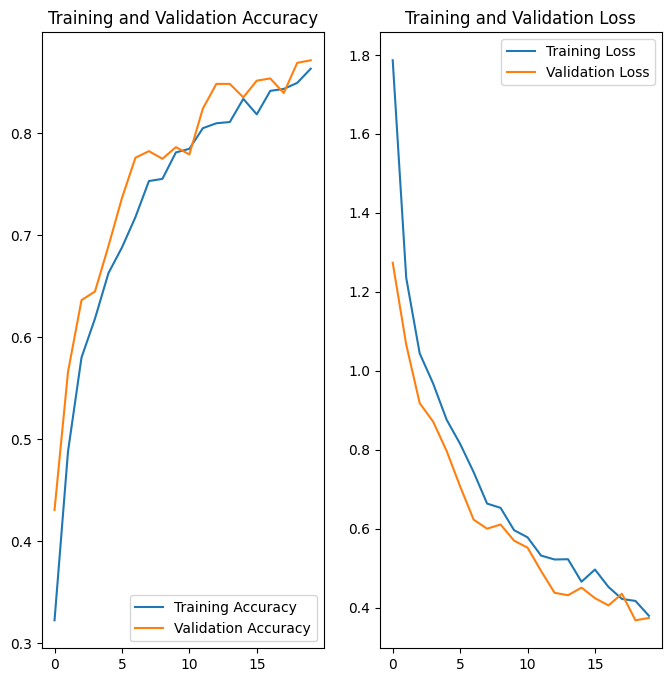

In [ ]:
import matplotlib.pyplot as plt
# Grafica la precisión y pérdida de entrenamiento y validación

acc = history_conv3.history['accuracy']
val_acc = history_conv3.history['val_accuracy']

loss = history_conv3.history['loss']
val_loss = history_conv3.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

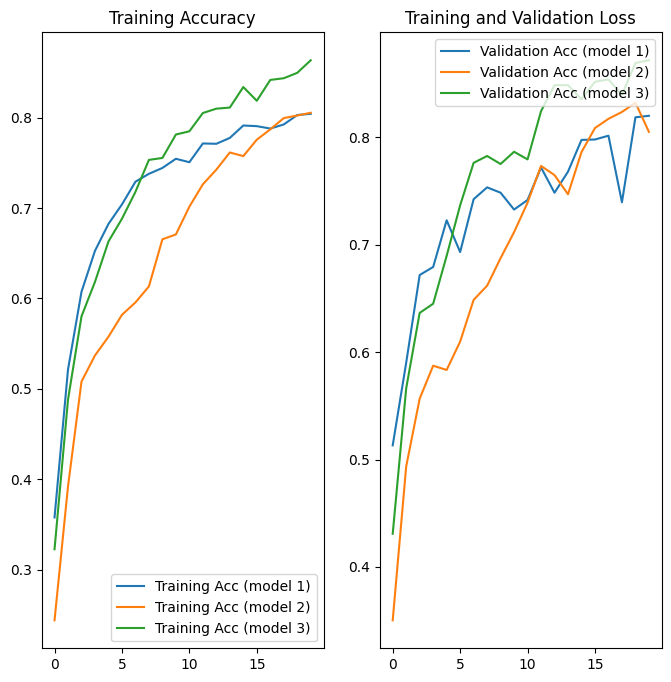

In [ ]:
acc1 = history_conv1.history['accuracy']
val_acc1 = history_conv1.history['val_accuracy']

acc2 = history_conv2.history['accuracy']
val_acc2 = history_conv2.history['val_accuracy']

acc3 = history_conv3.history['accuracy']
val_acc3 = history_conv3.history['val_accuracy']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label='Training Acc (model 1)')
plt.plot(epochs_range, acc2, label='Training Acc (model 2)')
plt.plot(epochs_range, acc3, label='Training Acc (model 3)')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_acc1, label='Validation Acc (model 1)')
plt.plot(epochs_range, val_acc2, label='Validation Acc (model 2)')
plt.plot(epochs_range, val_acc3, label='Validation Acc (model 3)')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Guardamos los modelos y los historiales
savemodel_path = '/content'
import pickle
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

with open(savemodel_path+'/history_conv1', 'wb') as file:
    model_history= History_trained_model(history_conv1.history, history_conv1.epoch, history_conv1.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

with open(savemodel_path+'/history_conv2', 'wb') as file:
    model_history= History_trained_model(history_conv2.history, history_conv2.epoch, history_conv2.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

with open(savemodel_path+'/history_conv3', 'wb') as file:
    model_history= History_trained_model(history_conv3.history, history_conv1.epoch, history_conv3.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Cargar el historial
with open(savemodel_path+'/history_conv1', 'rb') as file:
    history_conv1=pickle.load(file)

print(history_conv1.history)

{'loss': [1.5641077756881714, 1.1985514163970947, 1.0042660236358643, 0.8958991765975952, 0.8281849026679993, 0.7930499911308289, 0.7300721406936646, 0.7044556140899658, 0.7005958557128906, 0.6634923219680786, 0.6840217113494873, 0.6153550744056702, 0.6212178468704224, 0.6062542796134949, 0.5691632628440857, 0.5688237547874451, 0.5831654667854309, 0.5698076486587524, 0.5415046811103821, 0.5363654494285583], 'accuracy': [0.35785534977912903, 0.5215532779693604, 0.6074100732803345, 0.6527431607246399, 0.6824902296066284, 0.704043447971344, 0.7291592359542847, 0.737887442111969, 0.7443890571594238, 0.7545422315597534, 0.750712513923645, 0.7714641690254211, 0.7711079716682434, 0.7776095271110535, 0.7913252711296082, 0.7906127572059631, 0.7879408597946167, 0.7924830913543701, 0.8029034733772278, 0.8042393922805786], 'val_loss': [1.2298353910446167, 1.0155465602874756, 0.8694478273391724, 0.8465157747268677, 0.7557435035705566, 0.8382193446159363, 0.6975668668746948, 0.6693787574768066, 0.68

In [ ]:
# Guardar los modelos
model_conv1.save('/content/model_conv1.keras')
model_conv2.save('/content/model_conv2.keras')
model_conv3.save('/content/model_conv3.keras')

### Conclusiones
Como mencionamos anteriormente, la incorporación de bloques residuales ha mejorado notablemente la velocidad de entrenamiento, siendo comparable a la primera red neuronal no profunda. Además, se ha mejorado considerablemente la precisión, llegando en 20 épocas a una precisión sobre el conjunto de validación de 87%, y parece no haber convergido, por lo que se podría seguir entrenando el modelo esperando mejores métricas (HACER). Se podría evaluar el modelo sobre el conjunto de test (HACER).


## Transfer learning
En muchas ocasiones, o bien uno no cuenta con una cantidad masiva de datos para poder entrenar un modelo, o no cuenta con los recursos computacionales para entrenarlo (o ambas). El transfer learning es un método no propio al procesamiento de imágenes, el cual consiste en tomar un modelo pre-entrenado y continuar su entrenamiento con los datos propios. De esta manera, se ajusta el modelo pre-existente para la tarea que nosotros precisemos, aprovechando sus buenas métricas.

En el caso de redes neuronales convolucionales, se suelen congelar las capas convolucionales, y se redefinen las capas densas, entrenando solo estas. En el caso de que sea necesario, se puede entrenar también las capas convolucionales. Esto trae ciertos beneficios:

- Primero, el modelo puede ser entrenado más rápido, pues únicamente se están entrenando los parámetros de las redes neuronales densas.
- Segundo, podemos obtener buenos resultados sin una cantidad masiva de datos.

Antes de hacer la elección del modelo a tomar como checkpoint, se deben tomar ciertas consideraciones:
- Debemos analizar el dataset con el cual se entrenó, pues a pesar de que se puede utilizar un modelo entrenado sobre otra tarea a la nuestra, las imágenes o categorías del dataset deben ser similares a las del nuestro, no podemos utilizar un modelo entrenado sobre paisajes esperando que tenga buen desempeño en el reconocimiento facial.
- Debemos tener en cuenta la arquitectura del modelo a utilizar.

### Modelo: EfficientNetV2L
EfficientNet es un modelo entrenado sobre el dataset ImageNet. Este dataset cubre un panorama de imagenes muchísimo más amplio que el nuestro, por lo que, además de sus buenas métricas, es apto para nuestro caso.


In [16]:
def build_model4(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetV2B0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(100)(x)
    x = Dropout(0.1)(x)
    x = Dense(100)(x)
    x = Dense(50)(x)
    x = Dense(num_classes)(x)
    x = Activation("softmax")(x)

    return tf.keras.Model(i, x)



In [17]:
print("Building model")
model_conv4 = build_model4((height, width, channels), len(class_names))

model_conv4.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)#run_eagerly=True)

Building model
24274472/24274472 [==============================] - 1s 0us/step


In [19]:
# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history_conv4 = model_conv4.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=32,
)

Epoch 1/10
44/44 [==============================] - 34s 537ms/step - loss: 1.3146 - accuracy: 0.7528 - val_loss: 0.3683 - val_accuracy: 0.8870
Epoch 2/10
44/44 [==============================] - 12s 259ms/step - loss: 0.4216 - accuracy: 0.8663 - val_loss: 0.2868 - val_accuracy: 0.8999
Epoch 3/10
44/44 [==============================] - 13s 275ms/step - loss: 0.3273 - accuracy: 0.8839 - val_loss: 0.2724 - val_accuracy: 0.9024
Epoch 4/10
44/44 [==============================] - 13s 264ms/step - loss: 0.2981 - accuracy: 0.8845 - val_loss: 0.2660 - val_accuracy: 0.9052
Epoch 5/10
44/44 [==============================] - 14s 303ms/step - loss: 0.2939 - accuracy: 0.8916 - val_loss: 0.2591 - val_accuracy: 0.9031
Epoch 6/10
44/44 [==============================] - 13s 274ms/step - loss: 0.2735 - accuracy: 0.8977 - val_loss: 0.2594 - val_accuracy: 0.9066
Epoch 7/10
44/44 [==============================] - 12s 268ms/step - loss: 0.2538 - accuracy: 0.9052 - val_loss: 0.2652 - val_accuracy: 0.9052

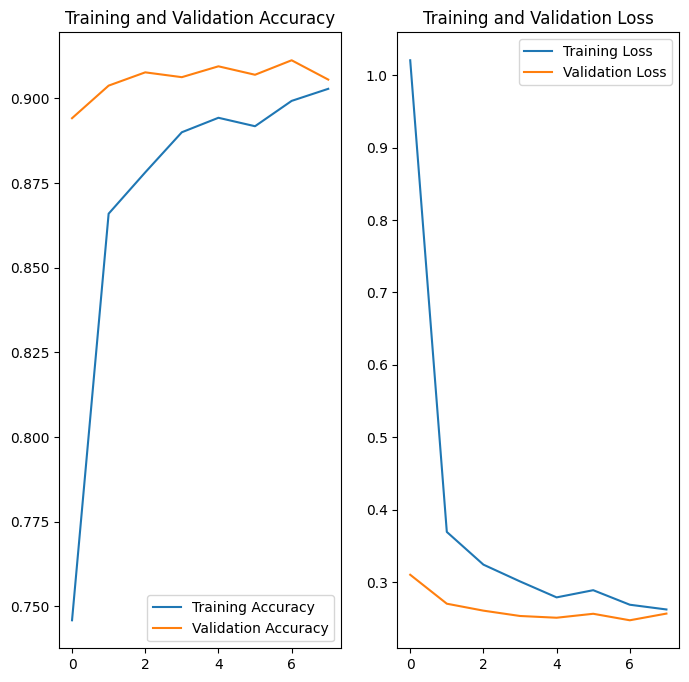

In [15]:
import matplotlib.pyplot as plt
# Grafica la precisión y pérdida de entrenamiento y validación

acc = history_conv4.history['accuracy']
val_acc = history_conv4.history['val_accuracy']

loss = history_conv4.history['loss']
val_loss = history_conv4.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Podemos ver que la precisión ha sido muy alta, llegando a ser del 91%, lo que prueba la eficacia de este método.